Data Initialization

In [88]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import pandas as pd

train_file_path = 'Google_Stock_Price_Train.csv'
test_file_path = 'Google_Stock_Price_Test.csv'
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

train_data_head = train_data.head()
test_data_head = test_data.head()

# Checking for missing values in both datasets
train_missing = train_data.isnull().sum()
test_missing = test_data.isnull().sum()

train_data_head, test_data_head, train_missing, test_missing

(       Date    Open    High     Low   Close      Volume
 0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
 1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
 2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
 3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
 4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800,
        Date    Open    High     Low   Close     Volume
 0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
 1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
 2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
 3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
 4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400,
 Date      0
 Open      0
 High      0
 Low       0
 Close     0
 Volume    0
 dtype: int64,
 Date      0
 Open      0
 High      0
 Low       0
 Close     0
 Volume    0
 dtype: int64)

In [90]:
train_data.shape, test_data.shape

((1258, 6), (20, 6))

Data Cleaning

In [91]:
# Removing commas from the 'Volume' column and convert it to numeric
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(int)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(int)

# Converting 'Date' column to datetime format for easier time-series analysis
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%m/%d/%Y')
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%m/%d/%Y')

# Converting numerical columns to float for consistency
numeric_columns = ['Open', 'High', 'Low', 'Close']
# train_data[numeric_columns] = train_data[numeric_columns].astype(float)
# test_data[numeric_columns] = test_data[numeric_columns].astype(float)

In [ ]:
columns_to_clean = ['Open', 'High', 'Low', 'Close']

In [93]:
# Ensuring all columns are treated correctly based on their type
for column in columns_to_clean:
    if train_data[column].dtype == 'object':
        train_data[column] = train_data[column].str.replace(',', '').astype(float)
    if test_data[column].dtype == 'object':
        test_data[column] = test_data[column].str.replace(',', '').astype(float)

# Formatted data
formatted_train_data = train_data.head()
formatted_test_data = test_data.head()

formatted_train_data, formatted_test_data


(        Date    Open    High     Low   Close    Volume
 0 2012-01-03  325.25  332.83  324.97  663.59   7380500
 1 2012-01-04  331.27  333.87  329.08  666.45   5749400
 2 2012-01-05  329.83  330.75  326.89  657.21   6590300
 3 2012-01-06  328.34  328.77  323.68  648.24   5405900
 4 2012-01-09  322.04  322.29  309.46  620.76  11688800,
         Date    Open    High     Low   Close   Volume
 0 2017-01-03  778.81  789.63  775.80  786.14  1657300
 1 2017-01-04  788.36  791.34  783.16  786.90  1073000
 2 2017-01-05  786.08  794.48  785.02  794.02  1335200
 3 2017-01-06  795.26  807.90  792.20  806.15  1640200
 4 2017-01-09  806.40  809.97  802.83  806.65  1272400)

Min Max Scaling

In [ ]:
scaler = MinMaxScaler()

# Columns excluding 'Date'
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']

# Fiting the scaler on the training data and transform both datasets
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()

train_data_scaled = scaler.fit_transform(train_data[columns_to_scale])
test_data_scaled = scaler.transform(test_data[columns_to_scale])



train_data_scaled.shape, test_data_scaled.shape



((1258, 5), (20, 5))

In [ ]:
# Creating sequences and reshaping for prediction
sequence_length = 10

print("X_test shape before reshape:", test_data_scaled.shape)

column_names = ['Open', 'High', 'Low', 'Close', 'Volume']

train_df = pd.DataFrame(train_data_scaled, columns=columns_to_scale)
test_df = pd.DataFrame(test_data_scaled, columns=columns_to_scale)


def create_sequences(df, target_column, sequence_length):
    X, y = [], []
    
    # Extracting features (X) and target (y)
    features = df.drop(columns=[target_column]).values  # Drop target column
    target = df[target_column].values
    
    # Loop over the data and target to create sequences
    for i in range(len(df) - sequence_length):
        X.append(features[i:i + sequence_length]) 
        y.append(target[i + sequence_length])  
        
    return np.array(X), np.array(y)



X_train, y_train = create_sequences(train_df, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_df, target_column='Close', sequence_length=sequence_length)


# Checking if X_test has at least two dimensions
if len(X_test.shape) < 2:
    raise ValueError(f"X_test does not have the correct shape for reshaping: {X_test.shape}")

# Shape of the data
print("X_train shape after sequencing:", X_train.shape)
print("X_test shape after sequencing:", X_test.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_test shape before reshape: (20, 5)
X_train shape after sequencing: (1248, 10, 4)
X_test shape after sequencing: (10, 10, 4)
X_train shape: (1248, 10, 4)
X_test shape: (10, 10, 4)


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Shapes of the split datasets
split_shapes = {
    "X_train_final_shape": X_train_final.shape,
    "y_train_final_shape": y_train_final.shape,
    "X_val_shape": X_val.shape,
    "y_val_shape": y_val.shape
}

split_shapes


{'X_train_final_shape': (998, 10, 4),
 'y_train_final_shape': (998,),
 'X_val_shape': (250, 10, 4),
 'y_val_shape': (250,)}

Vanilla RNN Model Initialization and Optimization using Bayesian Optimization

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to build the RNN model
def build_rnn_model(input_shape, units, learning_rate, optimizer_name, dropout_rate):
    model = Sequential([
        Input(shape=(X_train_final.shape[1], X_train_final.shape[2])),
        SimpleRNN(units, activation='tanh', input_shape=input_shape, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1)  
    ])
    optimizer = {
        'adam': tf.keras.optimizers.Adam(learning_rate=learning_rate),
        'sgd': tf.keras.optimizers.SGD(learning_rate=learning_rate)
    }[optimizer_name]
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Define the objective function for Bayesian Optimization
def objective(params):
    units, learning_rate, optimizer_name, batch_size, epochs, dropout_rate = params
    input_shape = (sequence_length, len(feature_columns)-1) 
    
    model = build_rnn_model(input_shape, units, learning_rate, optimizer_name, dropout_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0  # Suppress training output for optimization
    )
    
    return min(history.history['val_loss'])

# The parameter space for Bayesian Optimization
param_space = [
    Integer(10, 100, name='units'),              
    Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'), 
    Categorical(['adam', 'sgd'], name='optimizer_name'),         
    Integer(16, 128, name='batch_size'),         
    Integer(10, 50, name='epochs'),              
    Real(0.2, 0.5, name='dropout_rate')
]

# Bayesian Optimization
result = gp_minimize(
    func=objective,
    dimensions=param_space,
    n_calls=20,
    random_state=42,
    verbose=True
)

result



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.5391
Function value obtained: 0.0454
Current minimum: 0.0454
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.8935
Function value obtained: 0.0394
Current minimum: 0.0394
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 6.0047
Function value obtained: 0.0508
Current minimum: 0.0394
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 12.6241
Function value obtained: 0.0186
Current minimum: 0.0186
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.8702
Function value obtained: 0.0316
Current minimum: 0.0186
Iteration No: 6 started. Evaluatin

          fun: 0.01859200745820999
            x: [12, 0.0011208547084229365, 'adam', 21, 49, 0.2698314021290913]
    func_vals: [ 4.538e-02  3.944e-02 ...  2.253e-02  2.163e-02]
      x_iters: [[82, 0.00023273922280628724, 'sgd', 83, 28, 0.22999247474540088], [51, 0.0004649617447336334, 'adam', 89, 12, 0.41659963168004743], [94, 0.00010035927878780911, 'sgd', 85, 34, 0.20211989156591523], [12, 0.0011208547084229365, 'adam', 21, 49, 0.2698314021290913], [18, 0.0017249321573178998, 'adam', 126, 29, 0.4579821220208962], [71, 0.0007961566078062951, 'adam', 122, 33, 0.3156249507619749], [11, 0.0002895927274708839, 'adam', 93, 34, 0.4499584735208494], [26, 0.0006055098539300354, 'adam', 101, 27, 0.26238249886045667], [61, 0.00011551186209730989, 'sgd', 66, 26, 0.47799765973813835], [75, 0.0004498643077694105, 'sgd', 74, 48, 0.4533601546034455], [100, 0.01, 'sgd', 16, 10, 0.2], [100, 0.007004718837494212, 'adam', 16, 15, 0.2], [100, 0.001816831119921203, 'adam', 16, 24, 0.2], [10, 0.00521978

Final Model using Best Hyperparameters

In [ ]:
# Best hyperparameters from Bayesian optimization
best_params = {
    "units": 12,               
    "learning_rate": 0.0011208547084229365,    
    "optimizer_name": "adam",  
    "batch_size": 21,          
    "epochs": 49,
    "dropout_rate": 0.2698314021290913             
}

# Building the final model using the best hyperparameters

final_model = Sequential([
        Input(shape=(X_train_final.shape[1], X_train_final.shape[2])),
        SimpleRNN(best_params['units'], activation='tanh', return_sequences=False),
        Dense(1)
    ])

final_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mse', metrics=['mae'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
final_history = final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    batch_size=best_params["batch_size"],
    epochs=best_params["epochs"],
    callbacks=[early_stopping],
    verbose=1 
)

# Final training and validation loss
final_results = {
    "final_training_loss": final_history.history['loss'],
    "final_validation_loss": final_history.history['val_loss']
}

final_results


Epoch 1/49
48/48 [==============================] - 2s 12ms/step - loss: 0.5649 - mae: 0.5836 - val_loss: 0.0842 - val_mae: 0.2277
Epoch 2/49
48/48 [==============================] - 0s 6ms/step - loss: 0.0778 - mae: 0.2284 - val_loss: 0.0658 - val_mae: 0.2062
Epoch 3/49
48/48 [==============================] - 0s 5ms/step - loss: 0.0675 - mae: 0.2131 - val_loss: 0.0586 - val_mae: 0.1938
Epoch 4/49
48/48 [==============================] - 0s 6ms/step - loss: 0.0618 - mae: 0.2028 - val_loss: 0.0533 - val_mae: 0.1837
Epoch 5/49
48/48 [==============================] - 0s 6ms/step - loss: 0.0573 - mae: 0.1934 - val_loss: 0.0492 - val_mae: 0.1759
Epoch 6/49
48/48 [==============================] - 0s 6ms/step - loss: 0.0536 - mae: 0.1855 - val_loss: 0.0460 - val_mae: 0.1690
Epoch 7/49
48/48 [==============================] - 0s 6ms/step - loss: 0.0508 - mae: 0.1791 - val_loss: 0.0442 - val_mae: 0.1647
Epoch 8/49
48/48 [==============================] - 0s 6ms/step - loss: 0.0480 - mae: 0.1

{'final_training_loss': [0.5648882985115051,
  0.07778330147266388,
  0.06751000136137009,
  0.06183399260044098,
  0.057258229702711105,
  0.05358085408806801,
  0.05077492818236351,
  0.04802561551332474,
  0.04551513120532036,
  0.04289303719997406,
  0.040816545486450195,
  0.03935788571834564,
  0.03675772622227669,
  0.035096075385808945,
  0.034355394542217255,
  0.03211124613881111,
  0.030515316873788834,
  0.029227500781416893,
  0.027994291856884956,
  0.02706020511686802,
  0.028763312846422195,
  0.02721235156059265,
  0.026505934074521065,
  0.024907907471060753,
  0.0247736144810915,
  0.02391739934682846,
  0.02422027476131916,
  0.02385387383401394,
  0.023181039839982986,
  0.02265164442360401,
  0.023337597027420998,
  0.02270304597914219,
  0.02273709326982498,
  0.022967612370848656,
  0.022262295708060265,
  0.023093970492482185,
  0.021780284121632576,
  0.02356574870646],
 'final_validation_loss': [0.08420747518539429,
  0.06583943217992783,
  0.0585795789957046

Visualization

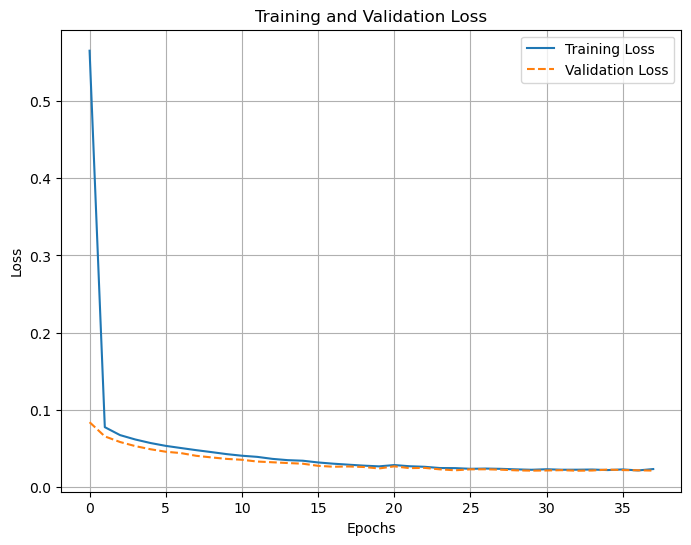

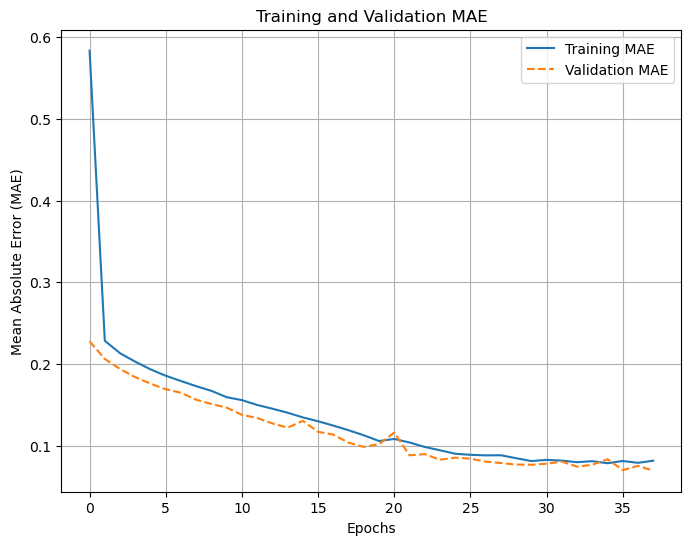

In [123]:
import matplotlib.pyplot as plt

# `final_history` contains the training history from the final model
loss = final_history.history['loss']
val_loss = final_history.history['val_loss']
mae = final_history.history['mae']
val_mae = final_history.history['val_mae']

# Training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Training and validation MAE
plt.figure(figsize=(8, 6))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE', linestyle='--')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()


Predictions using the Model

In [ ]:
predictions = final_model.predict(X_test)

# Rescale the predictions back to the original scale
predictions_rescaled = predictions.reshape(-1, 1)

# Rescale the actual y_test data back to the original scale for comparison
y_test_rescaled = y_test.reshape(-1, 1)



1/1 [==============================] - 0s 231ms/step


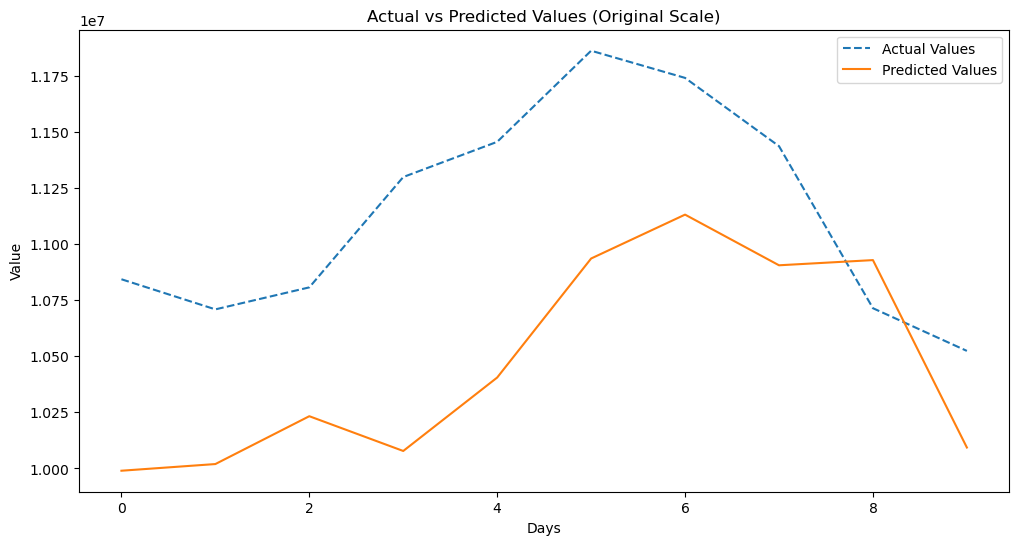

In [126]:
# Combining y_test_rescaled with dummy features to match the 5 features (X_test has 5)
dummy_features = np.zeros((y_test_rescaled.shape[0], 4))  # 4 dummy features (columns)
combined_test = np.hstack([dummy_features, y_test_rescaled]) 

# Inverse transform the combined data (X_test + y_test) using the scaler
combined_test_actual = scaler.inverse_transform(combined_test)

# Extract the actual target values (y_test) from the combined data
y_test_actual = combined_test_actual[:, -1]  # The last column is the target

# Combining prediction
combined_pred = np.hstack([dummy_features, predictions_rescaled])  
combined_pred_actual = scaler.inverse_transform(combined_pred)

# Extract the predicted target values
pred_actual = combined_pred_actual[:, -1]

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Values", linestyle='--')
plt.plot(pred_actual, label="Predicted Values")
plt.title("Actual vs Predicted Values (Original Scale)")
plt.xlabel("Days")
plt.ylabel("Value")
plt.legend()
plt.show()